In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import matplotlib.gridspec as gridspec
from matplotlib.ticker import ScalarFormatter
import math
from scipy.stats.mstats import gmean
from scipy.stats import gamma, poisson, linregress, beta, norm
from scipy import optimize
from scipy import interpolate
import time
import random
import pickle as pkl
from cratrcountr import *
from itertools import product
from matplotlib.patches import Arrow
%matplotlib inline

Set the production function to be a linear function with a slope of -2.0 in cumulative plot log-log space.

In [2]:
pf_slope = -2.0
pf = loglog_linear_pf(N1=0.001, slope=pf_slope)

Generate the synthetic data (or load from file).  Here, we iterate over an array of N values, N_array, which is evenly spaced in log space but rounded to integer values.  For the time-intensive calculations, we have pre-saved files with the results.  These are too large to be uploaded to GitHub.  The volume of data produced here is extremely large.  We're talking 31GB.  Do not be surprised if it takes over a minute to load.

As a convention, the time-intensive code is inside an if statement set to False.  To execute the code instead of loading pre-saved results from the file, just change False to True.

In [3]:
mt1 = time.time()

N_array = np.round([10.0**(i) for i in np.arange(1, 4, 0.1)]).astype('int')
synth_area = 10000
if False:
    N_array = np.round([10.0**(i) for i in np.arange(1, 4, 0.1)]).astype('int')
    N_search_data = [synth_fixed_N(N=N, 
                                 area=synth_area,
                                 pf=pf,
                                 dmin=1, dmax=1E5, 
                                 n_steps=100000) 
                       for N in N_array]
    with open('saved/N_search_data.pkl', 'wb') as f:
        pkl.dump(N_search_data, f)
    with open('N_array.pkl', 'wb') as f:
        pkl.dump(N_array, f)
else:
    with open('saved/N_search_data.pkl', 'rb') as f:
        N_search_data = pkl.load(f)
    
mt2 = time.time()
print('Total Runtime: ' + format_runtime(mt2 - mt1))

Total Runtime: 39.95276 seconds


Define the list of parameters to search over, as both SlopeSearchParams objects and keys to the dictionaries we use to store the results for different parameter combinations.

In [4]:
params_list = [
    SlopeSearchParams(plot_type=plot_type,
                     use_uncertainties=use_uncertainties,
                     pick_a_side=pick_a_side)
    for plot_type in ['unbinned', 'unbinned corrected', 'left']
    for use_uncertainties in [False, True]
    for pick_a_side in [False, True] if 
    use_uncertainties or not pick_a_side
]

key_list = [params.str for params in params_list]

Calculate the slopes for different plotting methods.  Here, we explore three plot types (unbinnned, unbinned corrected, and "binned") and three uncertainty approaches (no uncertainties, with averaged uncertainties, and with the side-picking approach to getting asymmetric uncertainties).  We call the "binned" plot "left" because it samples the cumulative function at the left-hand side of the "bin."  It's traditionally called "binning," but it is more of a sampling.

The scipy curve fitting functions do not allow for asymmetric error bars, so we have to use a workaround.  The first approach is to average the upper and lower bounds (in log space).  The second is the side-picking approach.  For this, we first get an initial slope estimate with the averaged uncertainties.  Then, we pick a side for each point, assigning the appropriate uncertaintes depending on whether the point falls above or below the initial slope estimate.  If any of the points switch sides after the sides have been picked, then we iterate the process until all points are on the correct side.

In variable names, we indicate that uncertainties are used with a u flag, and we indicate the side-picking is used with a p flag. 

This code takes a long time to run.  We have files with pre-saved results.

In [5]:
if False:
    
    slope_list_list_dict = {}
    for params in params_list:
        with open('saved/N_search.' + params.file_str + '.pkl', 'rb') as f:
            slope_list_list_dict[params.str] = pkl.load(f)[0]
    
    for params in params_list:

        t1 = time.time()

        slope_list_list = []
        failure_df_list = []
        switch_list_list = []
        for i in range(len(N_search_data)):
            synth_tuple = N_search_data[i]
            r_tuple = model_fitting_error(
                            synth_tuple[0], synth_tuple[1], synth_area,
                            pf=pf,
                            bin_width_exponent=neukum_bwe, 
                            use_uncertainties=params.use_uncertainties,
                            plot_type=params.plot_type, 
                            skip_zero_crater_bins=True,
                            reference_point=1.0, d_min=1.0,
                            start_at_reference_point=True,
                            n_pseudosteps=100000, skip_age=True,
                            pick_a_side=params.pick_a_side)
            if params.pick_a_side:
                slope_list, age_list, switch_list, failure_df_list = r_tuple
                switch_list_list.append(switch_list)
            else:
                slope_list, age_list, failure_df_list = r_tuple
            slope_list_list.append(slope_list)
            failure_df_list.append(failure_df_list)

        slope_list_list_dict[params.str] = slope_list_list
        
        with open('saved/N_search.' + params.file_str + '.pkl', 'wb') as f:
            if params.pick_a_side:
                pkl.dump(tuple([slope_list_list, switch_list_list, 
                                failure_df_list]), f)
            else:
                pkl.dump(tuple([slope_list_list, failure_df_list]), f)

        t2 = time.time()
        print('runtime: ' + format_runtime(t2 - t1))
        
else:
    
    slope_list_list_dict = {}
    for params in params_list:
        with open('saved/N_search.' + params.file_str + '.pkl', 'rb') as f:
            slope_list_list_dict[params.str] = pkl.load(f)[0]

Fit the slope data to log space normal random variables.

In [6]:
if False:
    t1 = time.time()
    slope_fit_matrix_dict = {key : np.array([
                    fit_slope_data(slope_list) for slope_list
                    in slope_list_list])
                    for key, slope_list_list
                    in slope_list_list_dict.items()}
    with open('saved/slope_fit_matrix_dict.N_search.pkl', 'wb') as f:
        pkl.dump(slope_fit_matrix_dict, f)
    t2 = time.time()
    print('runtime: ' + format_runtime(t2 - t1))
else:
    with open('saved/slope_fit_matrix_dict.N_search.pkl', 'rb') as f:
        slope_fit_matrix_dict = pkl.load(f)

Fit the max likelihood, lower error bar, and upper error bar data to functions that show how they vary with N.  For the max likelihood, we normalize it by dividing by the true slope to create the max factor.

In [7]:
max_factor_data_dict = {
    key : -1 * 10**slope_fit_matrix[:, 0] / pf_slope
    for key, slope_fit_matrix 
    in slope_fit_matrix_dict.items()
}
max_factor_fit_dict = {
    key : get_fit(fit_eq_max_factor, N_array, 
                  max_factor_data_dict[key]) 
    for key in key_list
}

lower_data_dict = {
    key : np.log10(slope_fit_matrix[:, 1])
    for key, slope_fit_matrix 
    in slope_fit_matrix_dict.items()
}
lower_fit_dict = {
    key : get_fit(polynomial_degree_5, 
                  np.log10(N_array),
    lower_data_dict[key]) 
    for key in key_list
}

upper_data_dict = {
    key : np.log10(slope_fit_matrix[:, 2])
    for key, slope_fit_matrix 
    in slope_fit_matrix_dict.items()
}
upper_fit_dict = {
    key : get_fit(polynomial_degree_5, 
                  np.log10(N_array),
                  upper_data_dict[key]) 
    for key in key_list
}

Set the dictionary of display colors for plotting purposes

In [8]:
cs = ['xkcd:dark sky blue', 'xkcd:vivid blue', 'xkcd:royal blue', 
      'xkcd:light orange', 'xkcd:orange', 'xkcd:dark orange', 
      'xkcd:pink', 'xkcd:pink red', 'xkcd:bright red']

c_dict = {key_list[i] : cs[i] for i in range(len(key_list))}

Plot the data and the fits

In [28]:
params_list[0].str

'unbinned'

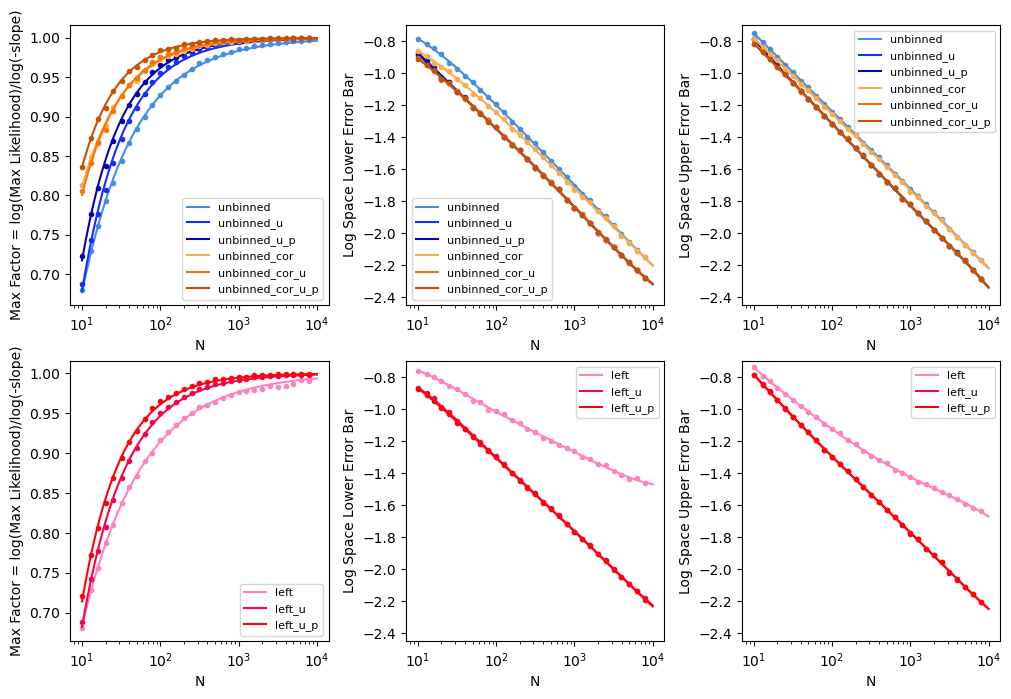

In [9]:
fig = plt.figure(figsize=(12, 8))

ax = plt.subplot(231)

X = np.logspace(1, 4, 500)
for key in key_list[:6]:
    Y = max_factor_data_dict[key]
    plt.plot(N_array, Y, '.', c=c_dict[key])
    plt.plot(X, max_factor_fit_dict[key].apply(X), 
             c=c_dict[key], label=key)
plt.legend(fontsize=8)
plt.xscale('log')
plt.xlabel('N')
plt.ylabel('Max Factor = log(Max Likelihood)/log(-slope)')

ax = plt.subplot(232)

X = np.logspace(1, 4, 500)
for key in key_list[:6]:
    Y = lower_data_dict[key]
    plt.plot(N_array, Y, '.', c=c_dict[key])
    plt.plot(X, lower_fit_dict[key].apply(np.log10(X)), 
             c=c_dict[key], label=key)
plt.legend(fontsize=8)
plt.xscale('log')
plt.ylim([-2.45, -0.7])
plt.xlabel('N')
plt.ylabel('Log Space Lower Error Bar')

ax = plt.subplot(233)

X = np.logspace(1, 4, 500)
for key in key_list[:6]:
    Y = upper_data_dict[key]
    plt.plot(N_array, Y, '.', c=c_dict[key])
    plt.plot(X, upper_fit_dict[key].apply(np.log10(X)), 
             c=c_dict[key], label=key)
plt.legend(fontsize=8)
plt.xscale('log')
plt.ylim([-2.45, -0.7])
plt.xlabel('N')
plt.ylabel('Log Space Upper Error Bar')

ax = plt.subplot(234)

X = np.logspace(1, 4, 500)
for key in key_list[6:]:
    Y = max_factor_data_dict[key]
    plt.plot(N_array, Y, '.', c=c_dict[key])
    plt.plot(X, max_factor_fit_dict[key].apply(X), 
             c=c_dict[key], label=key)
plt.legend(fontsize=8)
plt.xscale('log')
plt.xlabel('N')
plt.ylabel('Max Factor = log(Max Likelihood)/log(-slope)')

ax = plt.subplot(235)

X = np.logspace(1, 4, 500)
for key in key_list[6:]:
    Y = lower_data_dict[key]
    plt.plot(N_array, Y, '.', c=c_dict[key])
    plt.plot(X, lower_fit_dict[key].apply(np.log10(X)), 
             c=c_dict[key], label=key)
plt.legend(fontsize=8)
plt.xscale('log')
plt.ylim([-2.45, -0.7])
plt.xlabel('N')
plt.ylabel('Log Space Lower Error Bar')

ax = plt.subplot(236)

X = np.logspace(1, 4, 500)
for key in key_list[6:]:
    Y = upper_data_dict[key]
    plt.plot(N_array, Y, '.', c=c_dict[key])
    plt.plot(X, upper_fit_dict[key].apply(np.log10(X)), 
             c=c_dict[key], label=key)
plt.legend(fontsize=8)
plt.xscale('log')
plt.ylim([-2.45, -0.7])
plt.xlabel('N')
plt.ylabel('Log Space Upper Error Bar')

fig.subplots_adjust(hspace=0.2, wspace=0.3)

Save the different fits in a dictionary of NSearchFit objects.

In [10]:
NSearchFit_dict = {key : 
                   NSearchFit(max_factor_fit_dict[key], 
                              lower_fit_dict[key], 
                              upper_fit_dict[key]) 
                   for key in key_list}

Plot the fits and the raw data.

<AxesSubplot:>

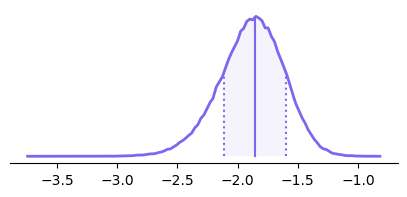

In [11]:
key = key_list[0]
example_N_i = 10
example_N = N_array[example_N_i]
example_N_slopes = slope_list_list_dict[key_list[0]][example_N_i]
example_N_pdf = make_pdf_from_samples(example_N_slopes, slope_data=True)
example_N_pdf.plot()

<AxesSubplot:>

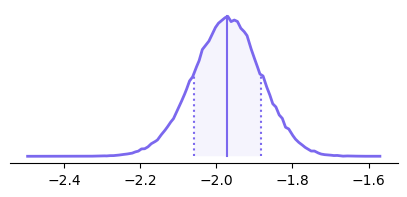

In [12]:
key = key_list[0]
example_N2_i = 20
example_N2 = N_array[example_N2_i]
example_N2_slopes = slope_list_list_dict[key_list[0]][example_N2_i]
example_N2_pdf = make_pdf_from_samples(example_N2_slopes, slope_data=True)
example_N2_pdf.plot()

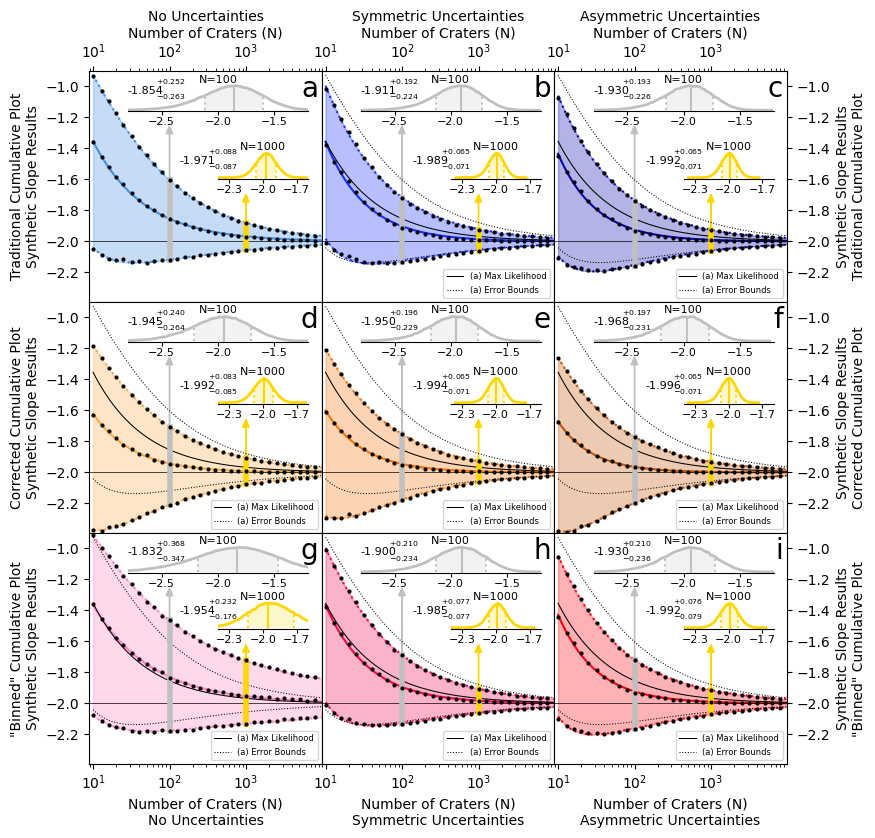

In [122]:
example_N_i = 10
example_N = N_array[example_N_i]
example_N2_i = 20
example_N2 = N_array[example_N2_i]

def plot_type_label(key):
    plot_type = key.split('_u')[0]
    plot_type_label_dict = {
        'unbinned' : 'Traditional Cumulative Plot',
        'unbinned_cor' : 'Corrected Cumulative Plot',
        'left' : '\"Binned\" Cumulative Plot'
    }
    return plot_type_label_dict[plot_type]

uncertainty_label_dict = {
    0 : 'No Uncertainties',
    1 : 'Symmetric Uncertainties',
    2 : 'Asymmetric Uncertainties'
}

fig = plt.figure(figsize=(9, 9))

xlim = [10**0.95, 10**3.99]
ylim = [-2.39, -0.9]
X = np.logspace(1, 4, 200, endpoint=True)
search_m = -2.0
h, w = 3, 3


for i in range(len(key_list)):
    ax = plt.subplot(h, w, i + 1)
    NSearchFit_dict[key_list[i]].plot(N=X, slope=search_m, color=cs[i],
                                      alpha=0.3)
    if i > 0:
        NSearchFit_dict[key_list[0]].plot(N=X, slope=search_m, lw=0.75, 
                                              color='black', alpha=0.0)
    plt.plot(xlim, [search_m, search_m], 'k', lw=0.5)
    mid, lower, upper = tuple(slope_fit_matrix_dict[key_list[i]][example_N_i])
    high, low = -1 * 10**(mid - lower), -1 * 10**(mid + upper)
    plt.plot([example_N, example_N], [low, high], color='silver', lw=4)
    mid, lower, upper = tuple(slope_fit_matrix_dict[key_list[i]][example_N2_i])
    high2, low2 = -1 * 10**(mid - lower), -1 * 10**(mid + upper)
    plt.plot([example_N2, example_N2], [low2, high2], color='gold', lw=4)
    plot_matrix(slope_fit_matrix_dict[key_list[i]], N_array)
    plt.xscale('log')
    plt.xlim(xlim)
    plt.ylim(ylim)
    if (i + 1) % w == 0:
        ax.yaxis.tick_right()
        ax.yaxis.set_label_position('right')
        plt.ylabel('Synthetic Slope Results\n' + plot_type_label(key_list[i]))
    elif i % w > 0:
        plt.yticks([])
        plt.ylabel('')
    else:
        plt.ylabel(plot_type_label(key_list[i]) + '\nSynthetic Slope Results')
    if i < w:
        ax.xaxis.tick_top()
        ax.xaxis.set_label_position('top')
        plt.xlabel(uncertainty_label_dict[i % w] + '\nNumber of Craters (N)')
    if i >= w * (h - 1):
        plt.xlabel('Number of Craters (N)\n' + uncertainty_label_dict[i % w])
    if i >= w and i < w * (h - 1):
        plt.xticks([])
    plt.text(0.985, 0.985, chr(ord('a') + i), transform=plt.gca().transAxes, 
             ha='right', va='top', size=20)
    plt.arrow(100, high, 0, -1.255 - high, color='silver',
              length_includes_head=True, head_width=20,
              head_length=0.05)
    plt.arrow(1000, high2, 0, -1.62 - high2 - 0.038 * (2 - i // w), color='gold',
              length_includes_head=True, head_width=200,
              head_length=0.05)
    line1 = Line2D([], [], color='black', lw=0.75, 
                   label='(a) Max Likelihood')
    line2 = Line2D([], [], color='black', lw=0.75, linestyle=':', 
                   label='(a) Error Bounds')
    if i > 0:
        plt.legend(handles=[line1, line2], fontsize=6, loc=4)
    
fig.subplots_adjust(hspace=0, wspace=0)

for i, j in product(range(w), range(h)):
    ax_inset = fig.add_axes([0.168 + 0.2587 * i, 0.835 - 0.2565 * j, 
                             0.2, 0.03])
    key = key_list[i + w * j]
    example_N_slopes = slope_list_list_dict[key][example_N_i]
    example_N_pdf = make_pdf_from_samples(example_N_slopes, slope_data=True)
    example_N_pdf.plot(ax=ax_inset, xlim=[-2.8, -1.2], 
                       color='silver', alpha=0.2, label=True,
                       label_text_size=8, label_color='black',
                       fig_size_adjustor=2.0, rounding_n=3)
    ax_inset.set_title('N=100', size=8, pad=0)
    ax_inset.tick_params(size=3, labelsize=8, pad=1)
    ax_inset.set_facecolor((0, 0, 0, 0))
    ax_inset = fig.add_axes([0.268 + 0.2587 * i, 0.76 - 0.25 * j, 
                             0.10, 0.03])
    example_N2_slopes = slope_list_list_dict[key][example_N2_i]
    example_N2_pdf = make_pdf_from_samples(example_N2_slopes, slope_data=True)
    example_N2_pdf.plot(ax=ax_inset, xlim=[-2.4, -1.6], 
                        color='gold', alpha=0.2, label=True,
                        label_text_size=8, label_color='black',
                        fig_size_adjustor=2.0, rounding_n=3,
                        label_shift_x=-0.34, label_shift_y=-0.1)
    ax_inset.set_title('N=1000', size=8, pad=0)
    ax_inset.set_xticks([-2.3, -2.0, -1.7])
    ax_inset.tick_params(size=3, labelsize=8, pad=1)
    ax_inset.set_facecolor((0, 0, 0, 0))

pfig = plt.gcf()
pfig.savefig('../synthfigs/N_search.pdf', bbox_inches='tight')

Make a figure wiht just the first row.

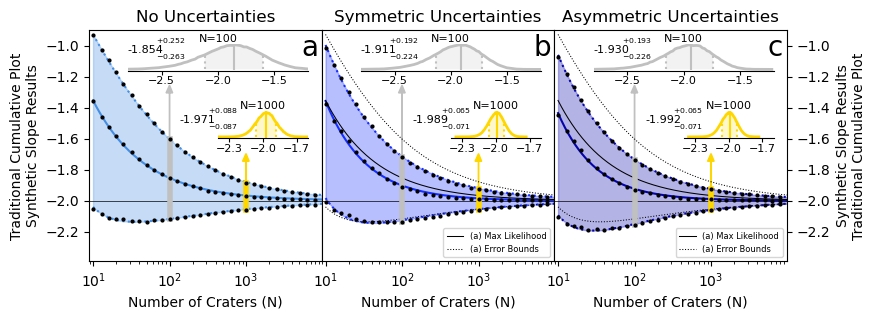

In [124]:
example_N_i = 10
example_N = N_array[example_N_i]
example_N2_i = 20
example_N2 = N_array[example_N2_i]

def plot_type_label(key):
    plot_type = key.split('_u')[0]
    plot_type_label_dict = {
        'unbinned' : 'Traditional Cumulative Plot',
        'unbinned_cor' : 'Corrected Cumulative Plot',
        'left' : '\"Binned\" Cumulative Plot'
    }
    return plot_type_label_dict[plot_type]

uncertainty_label_dict = {
    0 : 'No Uncertainties',
    1 : 'Symmetric Uncertainties',
    2 : 'Asymmetric Uncertainties'
}

fig = plt.figure(figsize=(9, 9))

xlim = [10**0.95, 10**3.99]
ylim = [-2.39, -0.9]
X = np.logspace(1, 4, 200, endpoint=True)
search_m = -2.0
h, w = 3, 3


for i in range(3):
    ax = plt.subplot(h, w, i + 1)
    NSearchFit_dict[key_list[i]].plot(N=X, slope=search_m, color=cs[i],
                                      alpha=0.3)
    if i > 0:
        NSearchFit_dict[key_list[0]].plot(N=X, slope=search_m, lw=0.75, 
                                              color='black', alpha=0.0)
    plt.plot(xlim, [search_m, search_m], 'k', lw=0.5)
    mid, lower, upper = tuple(slope_fit_matrix_dict[key_list[i]][example_N_i])
    high, low = -1 * 10**(mid - lower), -1 * 10**(mid + upper)
    plt.plot([example_N, example_N], [low, high], color='silver', lw=4)
    mid, lower, upper = tuple(slope_fit_matrix_dict[key_list[i]][example_N2_i])
    high2, low2 = -1 * 10**(mid - lower), -1 * 10**(mid + upper)
    plt.plot([example_N2, example_N2], [low2, high2], color='gold', lw=4)
    plot_matrix(slope_fit_matrix_dict[key_list[i]], N_array)
    plt.xscale('log')
    plt.xlim(xlim)
    plt.ylim(ylim)
    if (i + 1) % w == 0:
        ax.yaxis.tick_right()
        ax.yaxis.set_label_position('right')
        plt.ylabel('Synthetic Slope Results\n' + plot_type_label(key_list[i]))
    elif i % w > 0:
        plt.yticks([])
        plt.ylabel('')
    else:
        plt.ylabel(plot_type_label(key_list[i]) + '\nSynthetic Slope Results')
    plt.xlabel('Number of Craters (N)')
    plt.title(uncertainty_label_dict[i % w])
    plt.text(0.985, 0.985, chr(ord('a') + i), transform=plt.gca().transAxes, 
             ha='right', va='top', size=20)
    plt.arrow(100, high, 0, -1.255 - high, color='silver',
              length_includes_head=True, head_width=20,
              head_length=0.05)
    plt.arrow(1000, high2, 0, -1.62 - high2 - 0.038 * (2 - i // w), color='gold',
              length_includes_head=True, head_width=200,
              head_length=0.05)
    line1 = Line2D([], [], color='black', lw=0.75, 
                   label='(a) Max Likelihood')
    line2 = Line2D([], [], color='black', lw=0.75, linestyle=':', 
                   label='(a) Error Bounds')
    if i > 0:
        plt.legend(handles=[line1, line2], fontsize=6, loc=4)
    
fig.subplots_adjust(hspace=0, wspace=0)

for i, j in product(range(w), range(1)):
    ax_inset = fig.add_axes([0.168 + 0.2587 * i, 0.835 - 0.2565 * j, 
                             0.2, 0.03])
    key = key_list[i + w * j]
    example_N_slopes = slope_list_list_dict[key][example_N_i]
    example_N_pdf = make_pdf_from_samples(example_N_slopes, slope_data=True)
    example_N_pdf.plot(ax=ax_inset, xlim=[-2.8, -1.2], 
                       color='silver', alpha=0.2, label=True,
                       label_text_size=8, label_color='black',
                       fig_size_adjustor=2.0, rounding_n=3)
    ax_inset.set_title('N=100', size=8, pad=0)
    ax_inset.tick_params(size=3, labelsize=8, pad=1)
    ax_inset.set_facecolor((0, 0, 0, 0))
    ax_inset = fig.add_axes([0.268 + 0.2587 * i, 0.76 - 0.25 * j, 
                             0.10, 0.03])
    example_N2_slopes = slope_list_list_dict[key][example_N2_i]
    example_N2_pdf = make_pdf_from_samples(example_N2_slopes, slope_data=True)
    example_N2_pdf.plot(ax=ax_inset, xlim=[-2.4, -1.6], 
                        color='gold', alpha=0.2, label=True,
                        label_text_size=8, label_color='black',
                        fig_size_adjustor=2.0, rounding_n=3,
                        label_shift_x=-0.34, label_shift_y=-0.1)
    ax_inset.set_title('N=1000', size=8, pad=0)
    ax_inset.set_xticks([-2.3, -2.0, -1.7])
    ax_inset.tick_params(size=3, labelsize=8, pad=1)
    ax_inset.set_facecolor((0, 0, 0, 0))

pfig = plt.gcf()
pfig.savefig('../synthfigs/N_search_traditional.pdf', bbox_inches='tight')

Demonstration that the reverse fit does not vary with slope.  It has a constant slope factor, lower bounds, and upper bounds.  The maximum likelihood value will vary with slope, but it can always be found by applying the constant slope factor.  Because of this, we only need to run the reverse fit at one slope.  We choose -2.5, but this is arbitrary.

In [295]:
fit = NSearchFit_dict[key_list[4]]
observed_slope_array = -1 * np.logspace(np.log10(0.5), np.log10(4.5), 50, endpoint=False)
slope_reverse_matrix = np.array([fit.reverse_model(N=20, slope=slope)
                                 for slope in observed_slope_array])

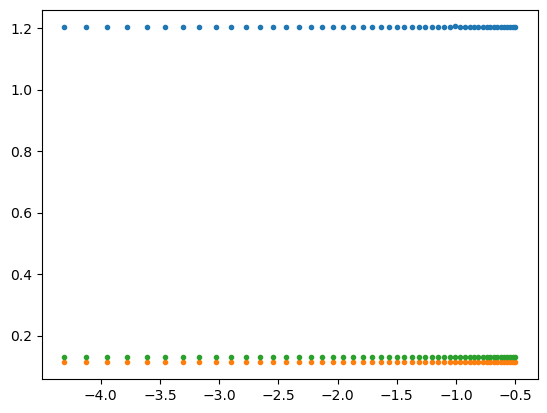

In [299]:
X = observed_slope_array
Y = tuple(slope_reverse_matrix.T)[0] / np.log10(-1 * X)
plt.plot(X, Y, '.')
Y = tuple(slope_reverse_matrix.T)[1]
plt.plot(X, Y, '.')
Y = tuple(slope_reverse_matrix.T)[2]
plt.plot(X, Y, '.')

Calculate the reverse problem at an array of N values.  We must choose an example observed slope, and we choose -2.5 (see above).

In [12]:
key_list_restricted = key_list[:6]

reverse_m = -2.5
reverse_Ns = np.logspace(1, 4, 200, endpoint=True)
if False:
    t1 = time.time()
    reverse_matrix_dict = {}
    for key in key_list_restricted:
        fit = NSearchFit_dict[key]
        reverse_matrix = np.array([
                fit.reverse_model(N=N, slope=reverse_m) 
                for N in reverse_Ns])
        reverse_matrix_dict[key] = reverse_matrix
        with open('saved/reverse_matrix_' + key + '.pkl', 'wb') as f:
            pkl.dump(reverse_matrix, f)
    t2 = time.time()
    print('runtime: ' + format_runtime(t2 - t1))
else:
    key_list_restricted = key_list[:6]
    reverse_matrix_dict = {}
    for key in key_list_restricted:
        with open('saved/reverse_matrix_' + key + '.pkl', 'rb') as f:
            reverse_matrix_dict[key] = pkl.load(f)

Fit the reverse problem data to model the variation with N.

In [15]:
ReverseFit_dict = {key : get_reverse_fit(reverse_matrix_dict[key], 
                                         slope=reverse_m, 
                                         X=np.log10(reverse_Ns))
                   for key in key_list_restricted}

with open('saved/ReverseFit_dict.pkl', 'wb') as f:
    pkl.dump(ReverseFit_dict, f)

Plot the final reverse model as a function of N, showing the random variable error model corresponding to an observation of a slope of -2.5 at various N under different plotting methods.

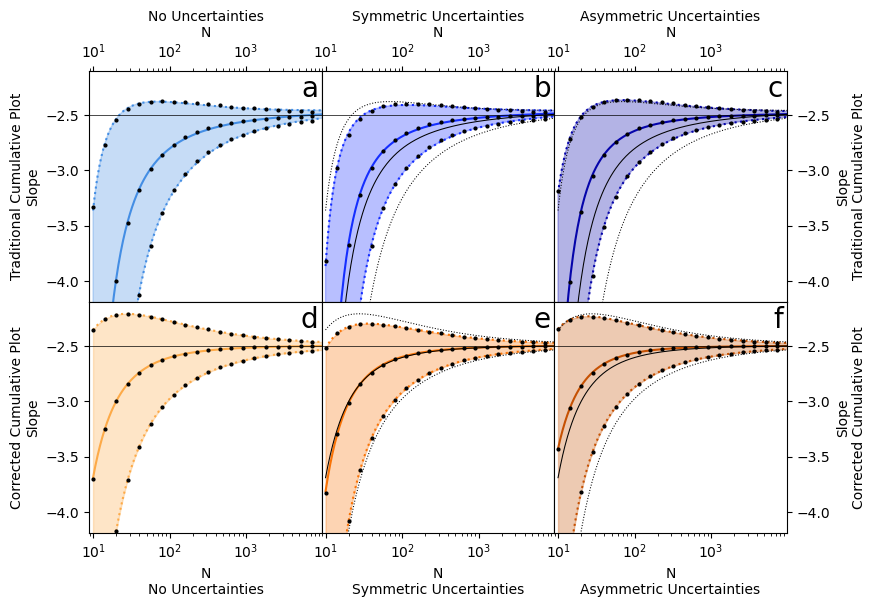

In [389]:
def plot_type_label(key):
    plot_type = key.split('_u')[0]
    plot_type_label_dict = {
        'unbinned' : 'Traditional Cumulative Plot',
        'unbinned_cor' : 'Corrected Cumulative Plot',
        'left' : 'Binned Cumulative Plot'
    }
    return plot_type_label_dict[plot_type]

uncertainty_label_dict = {
    0 : 'No Uncertainties',
    1 : 'Symmetric Uncertainties',
    2 : 'Asymmetric Uncertainties'
}

fig = plt.figure(figsize=(9, 6))

xlim = [10**0.95, 10**3.99]
ylim = [-4.19, -2.1]
X = np.logspace(1, 4, 200, endpoint=True)
search_m = -2.5
h, w = 2, 3


for i in range(len(key_list_restricted)):
    ax = plt.subplot(h, w, i + 1)
    ReverseFit_dict[key_list_restricted[i]].plot(
            N=X, slope=search_m, color=cs[i], alpha=0.3)
    if i % w > 0:
        ReverseFit_dict[key_list_restricted[i - i % w]].plot(X, 
                slope=search_m, lw=0.75, color='black', alpha=0.0)
    plt.plot(xlim, [search_m, search_m], 'k', lw=0.5)
    fitting_data = reverse_matrix_dict[key_list_restricted[i]][::10]
    plot_matrix(fitting_data, reverse_Ns[::10])
    plt.xscale('log')
    plt.xlim(xlim)
    plt.ylim(ylim)
    if (i + 1) % w == 0:
        ax.yaxis.tick_right()
        ax.yaxis.set_label_position('right')
        plt.ylabel('Slope\n' + plot_type_label(key_list_restricted[i]))
    elif i % w > 0:
        plt.yticks([])
        plt.ylabel('')
    else:
        plt.ylabel(plot_type_label(key_list_restricted[i]) + '\nSlope')
    if i < w:
        ax.xaxis.tick_top()
        ax.xaxis.set_label_position('top')
        plt.xlabel(uncertainty_label_dict[i % w] + '\nN')
    if i >= w * (h - 1):
        plt.xlabel('N\n' + uncertainty_label_dict[i % w])
    if i >= w and i < w * (h - 1):
        plt.xticks([])
    plt.text(0.985, 0.985, chr(ord('a') + i), transform=plt.gca().transAxes, 
             ha='right', va='top', size=20)
    
fig.subplots_adjust(hspace=0, wspace=0)

pfig = plt.gcf()
pfig.savefig('../synthfigs/N_search_reverse.pdf', bbox_inches='tight')

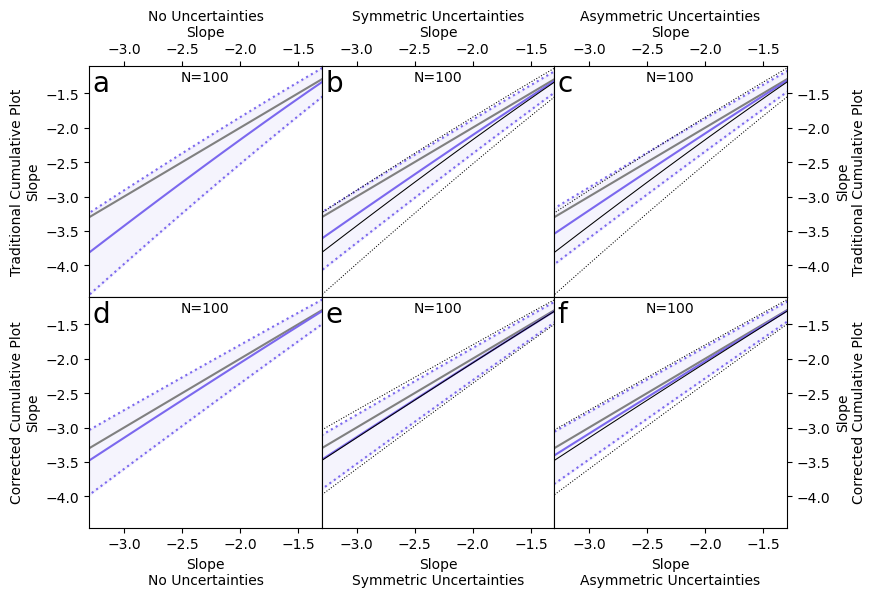

In [314]:
def plot_type_label(key):
    plot_type = key.split('_u')[0]
    plot_type_label_dict = {
        'unbinned' : 'Traditional Cumulative Plot',
        'unbinned_cor' : 'Corrected Cumulative Plot',
        'left' : 'Unbinned Cumulative Plot'
    }
    return plot_type_label_dict[plot_type]

uncertainty_label_dict = {
    0 : 'No Uncertainties',
    1 : 'Symmetric Uncertainties',
    2 : 'Asymmetric Uncertainties'
}

fig = plt.figure(figsize=(9, 6))

xlim = [-3.3, -1.3]
ylim = [-4.45, -1.1]
X = np.logspace(1, 4, 200, endpoint=True)
search_m = -2.5
h, w = 2, 3
N = 100

for i in range(len(key_list_restricted)):
    ax = plt.subplot(h, w, i + 1)
    ReverseFit_dict[key_list_restricted[i]].slope_plot(N=N)
    if i % w > 0:
        ReverseFit_dict[key_list_restricted[i - i % w]].slope_plot(N=N,
                color='black', alpha=0.0, lw=0.75,
                print_equal_slope_line=False)
    plt.xlim(xlim)
    plt.ylim(ylim)
    if (i + 1) % w == 0:
        ax.yaxis.tick_right()
        ax.yaxis.set_label_position('right')
        plt.ylabel('Slope\n' + plot_type_label(key_list_restricted[i]))
    elif i % w > 0:
        plt.yticks([])
        plt.ylabel('')
    else:
        plt.ylabel(plot_type_label(key_list_restricted[i]) + '\nSlope')
    if i < w:
        ax.xaxis.tick_top()
        ax.xaxis.set_label_position('top')
        plt.xlabel(uncertainty_label_dict[i % w] + '\nSlope')
    if i >= w * (h - 1):
        plt.xlabel('Slope\n' + uncertainty_label_dict[i % w])
    if i >= w and i < w * (h - 1):
        plt.xticks([])
    plt.text(0.015, 0.985, chr(ord('a') + i), transform=plt.gca().transAxes, 
             ha='left', va='top', size=20)
    plt.text(np.mean(xlim), np.percentile(ylim, 95), 'N=' + str(N), 
             ha='center', va='center')
    
fig.subplots_adjust(hspace=0, wspace=0)

pfig = plt.gcf()
pfig.savefig('../synthfigs/N_search_reverse_slope_plot.pdf', bbox_inches='tight')